## Importing packages and defining functions

In [1]:
from dask.distributed import LocalCluster, Client
import dask.array
import datetime
from datetime import date 
from datetime import datetime
import glob
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage.measurements import label, find_objects
import xarray as xr

In [2]:
# This is for running on Gadi

import os
import dask.distributed
threads_per_worker = 1
try:
    c # Already running
except NameError:
    c = dask.distributed.Client(
        n_workers=int(os.environ['PBS_NCPUS'])//threads_per_worker,
        threads_per_worker=threads_per_worker,
        memory_limit=f'{4*threads_per_worker}gb',
        local_directory=os.path.join(os.environ['PBS_JOBFS'],
                                     'dask-worker-space')
    )
c

KeyError: 'PBS_NCPUS'

In [3]:
# This function will make the clim and thresh repeatable so that the shapes of clim, thresh and dailytmax are equal.

def fix(ds):
    # This was the code fixed to make the clim and thresh repeatable so that the shapes of clim, thresh and obs are equal.
    trial = ds
    i = 0
    while i < 37:  # <-- Here, 37 corresponds to the number of years in obs dataset 
        trial = xr.concat([trial, ds], 'dayofyear')
        i+=1
    trial = trial.isel(dayofyear = slice(0,13514))
    # to specify the dates/time 
    trial.coords['dayofyear'] = np.arange(date(1982,1,1).toordinal(),date(2018,12,31).toordinal()+1) 
    
    # This code was used to rename the dayofyear dimension to time.
    trial['time'] = trial['dayofyear']
    del trial['dayofyear']
    trial = trial.rename({'dayofyear': 'time'})
    
    t = np.arange(date(1982,1,1).toordinal(),date(2018,12,31).toordinal()+1)
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    trial.coords['time'] = dates

    return trial

In [4]:
def calc_severity(data, new_climatology, new_threshold):

    threshold_anomaly = new_threshold - new_climatology
    
    # Ignore divide by zero errors
    nperr = np.seterr(divide='ignore')

    def calc_severity_helper(da, *args, **kwargs):
        if da.size == 0:
            return da
    
        coords = {}
        for k,v in obs_aus_tmax.coords.items():
            if k == 'time':
                continue
            coords[k] = slice(v[0], v[-1])
    
        anomaly = da - new_climatology.sel(coords)
        severity = anomaly / threshold_anomaly.sel(coords)
        return severity

    data = data.chunk({'time': None})
    r = data.map_blocks(calc_severity_helper)
    
    np.seterr(**nperr)
    
    return r

In [5]:
def atleastn(da, n, dim='time'):
    """
    Return values with at least n contiguous points around them
    """

    def atleastn_helper(array, n, axis):
        count = np.zeros_like(np.take(array, 0,axis=axis), dtype='i4')
        mask = np.empty_like(np.take(array, 0,axis=axis), dtype='bool')
        mask = True
    
        for i in range(array.shape[axis]):
            array_slice = np.take(array, i, axis=axis)
        
            # Increase the count when there is a valid value, reset when there is not
            count = np.where(array_slice, count + 1, 0)
        
            # Add new points when the contiguous count exceeds the threshold
            mask = np.where(count >= n, False, mask)
        
        out_slice = np.take(array, array.shape[axis]//2, axis=axis)
        return np.ma.masked_where(mask, out_slice)
    
    def atleastn_dask_helper(array, axis, **kwargs):
        r = dask.array.map_blocks(atleastn_helper, array, drop_axis=axis, axis=axis, n=n, dtype=array.dtype)
        return r
    
    if isinstance(da.data, dask.array.Array):
        reducer = atleastn_dask_helper
    else:
        reducer = atleastn_helper
        
    return da.rolling({dim: n*2-1}, center=True, min_periods=n).reduce(reducer, n=n)

## Opening files 

In [6]:
mean_climatology = xr.open_dataarray('/g/data/e14/cp3790/Charuni/climatology-australia.nc')
threshold = xr.open_dataarray('/g/data/e14/cp3790/Charuni/threshold-australia.nc')

In [7]:
files = sorted(glob.glob('/g/data/e14/cp3790/Charuni/ERA5-new/era5_dailytmax_*.nc'))

obs_aus = (xr.open_mfdataset(files, combine='nested', concat_dim='time', chunks={'latitude': 10})
           .sel(time=slice('1982', '2018'), longitude=slice(113, 154), latitude=slice(-10, -44)))
obs_aus_tmax = obs_aus["dmax"]
obs_aus_tmax.attrs['units'] = 'deg C'

Making the mean climatology and 90th percentile climatology (threshold) repeatable so that their sizes are compatible with the size of the daily tmax data

In [8]:
new_climatology = fix(mean_climatology) #this is now the same length as dailytmax

In [9]:
new_threshold = fix(threshold) #this is now the same length as dailytmax

## Calculations 

Calculating severity using 'map_blocks()', which enables the severity calculation to run on each timeseries chunk, facilitating parallel computation 

In [10]:
thw_severity = calc_severity(obs_aus_tmax, new_climatology, new_threshold)

In [11]:
%%time
%matplotlib inline
#hws_preDur = xarray.open_dataset('/scratch/w35/saw562/helpdesk/severity.nc', chunks={'time': 100, 'latitude': 100, 'longitude': 100})

candidates = thw_severity.where(thw_severity > 0) #identifying instances where the severity is a positive value

CPU times: user 117 ms, sys: 63 ms, total: 180 ms
Wall time: 360 ms


Masking out points where there are less than 3 contiguous points in the time dimension

CPU times: user 37.2 s, sys: 6min 37s, total: 7min 14s
Wall time: 6min 34s


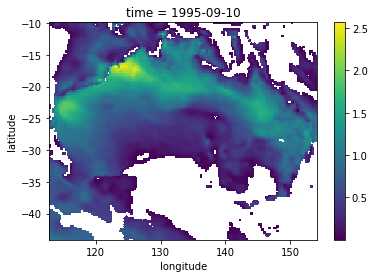

In [12]:
%%time

atleastn(candidates, n=3).isel(time=5000).plot()

## Saving to netcdf

In [13]:
%%time

# Save to a file
oscar = atleastn(candidates, n=3)

xr.Dataset({'severity': oscar}).to_netcdf('/g/data/e14/cp3790/Charuni/filtered_severity_test.nc',
                                              encoding={'severity': 
                                                        {'chunksizes': (100, oscar.shape[1], oscar.shape[2]),
                                                         'zlib': True,
                                                         'shuffle': True, 
                                                         'complevel': 2}})                                      

CPU times: user 4min 16s, sys: 3min 5s, total: 7min 21s
Wall time: 6min 20s
